In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, repeat
from scipy.interpolate import UnivariateSpline
import pandas as pd

%matplotlib inline

## Image preprocessing

In [2]:
def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([]), plt.yticks([])

In [3]:
original = cv.cvtColor(cv.imread('../data/368y5.png'), cv.COLOR_RGB2GRAY)

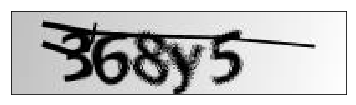

In [4]:
show_image(original)

Invert pixel intensities

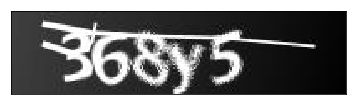

In [5]:
original_inverted = 255 - original
show_image(original_inverted)

Apply thresholding

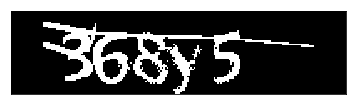

In [6]:
ret, thresholded = cv.threshold(original_inverted, 180, 255, cv.THRESH_BINARY)
show_image(thresholded)

Apply morphological transformations to clean the image

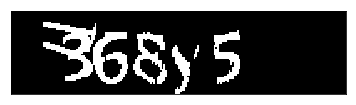

In [7]:
kernel = np.array([
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0]
]).astype(np.uint8)
kernel2 = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0]
]).astype(np.uint8)
processed = cv.morphologyEx(thresholded, cv.MORPH_ERODE, kernel2)
processed = cv.morphologyEx(processed, cv.MORPH_DILATE, kernel2)
show_image(processed)

Apply edge detector

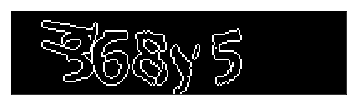

In [8]:
processed = cv.Laplacian(processed, 5).clip(0, 255).astype(np.uint8)
show_image(processed)

## Find image contours

In [9]:
contours, hierachy = cv.findContours(processed, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE )

In [10]:
rects = [cv.boundingRect(contour) for contour in contours]
rects_width, rects_height = [rect[2] for rect in rects], [rect[3] for rect in rects]
rects_ratio = [rect[2] / rect[3] for rect in rects]
rects_area = [width * height for width, height in zip(rects_width, rects_height)]

areas = [cv.contourArea(contour) for contour in contours]
extent = [float(area) / rect_area for rect_area, area in zip(rects_area, areas)]

hulls = [cv.convexHull(contour) for contour in contours]
hull_areas = [cv.contourArea(hull) for hull in hulls]

#solidity = [float(area) / hull_area for area, hull_area in zip(areas, hull_areas)]

#eq_diameter = [np.sqrt(4*area/np.pi) for area in areas]

orientation_angles = [cv.fitEllipse(contour)[2] if contour.shape[0] >= 5 else None for contour in contours]

perimeter = [cv.arcLength(contour, True) for contour in contours]

print('Contours properties')
pd.DataFrame.from_dict({
    'width': rects_width,
    'height': rects_height,
    'ratio': np.round(rects_ratio, 2),
    'extent': np.round(extent, 2),
#    'solidity': np.round(solidity, 2),
#    'eq diameter': np.round(eq_diameter, 2),
    'orientation angles': [round(angle, 2) if angle is not None else '---' for angle in orientation_angles],
    'perimeter': np.round(perimeter, 2)
})

Contours properties


,width,height,ratio,extent,orientation angles,perimeter
0,1,1,1.00,0.00,---,0.00
1,5,10,0.50,0.40,17.76,21.31
2,5,10,0.50,0.40,17.76,21.31
3,13,30,0.43,0.01,175.58,150.02
4,2,3,0.67,0.08,---,5.41
5,22,33,0.67,0.67,172.67,103.15
6,13,12,1.08,0.51,128,36.63
7,3,3,1.00,0.22,---,5.66
8,10,9,1.11,0.51,120.85,26.38
9,22,33,0.67,0.49,173.27,185.92


In [11]:
hierachy.shape

(1, 18, 4)

In [12]:
print('Contour hierachy info:')
pd.DataFrame.from_dict(dict([(col, data.flatten()) for col, data in
                        zip(['Next', 'Previous', 'First Child', 'Parent'], np.split(hierachy, hierachy.shape[2], axis=2))]))

Contour hierachy info:


,Next,Previous,First Child,Parent
0,1,-1,-1,-1
1,3,0,2,-1
2,-1,-1,-1,1
3,4,1,-1,-1
4,5,3,-1,-1
5,10,4,6,-1
6,7,-1,-1,5
7,8,6,-1,5
8,9,7,-1,5
9,-1,8,-1,5


In [13]:
n = len(contours)
contour_levels = np.zeros([n]).astype(np.uint8)

contour_parent = hierachy[0, :, 3]
contour_children = [set() for k in range(0, n)]
for k in range(0, n):
    parent = contour_parent[k]
    if parent != -1:
        contour_children[parent].add(k)

A = set(np.nonzero(contour_parent == -1)[0])
B = set(range(0, n)) - A


while len(B) > 0:
    C = set()
    for k in A:
        for child in contour_children[k]:
            B.remove(child)
            C.add(child)
            contour_levels[child] = contour_levels[k] + 1
    A.update(C)

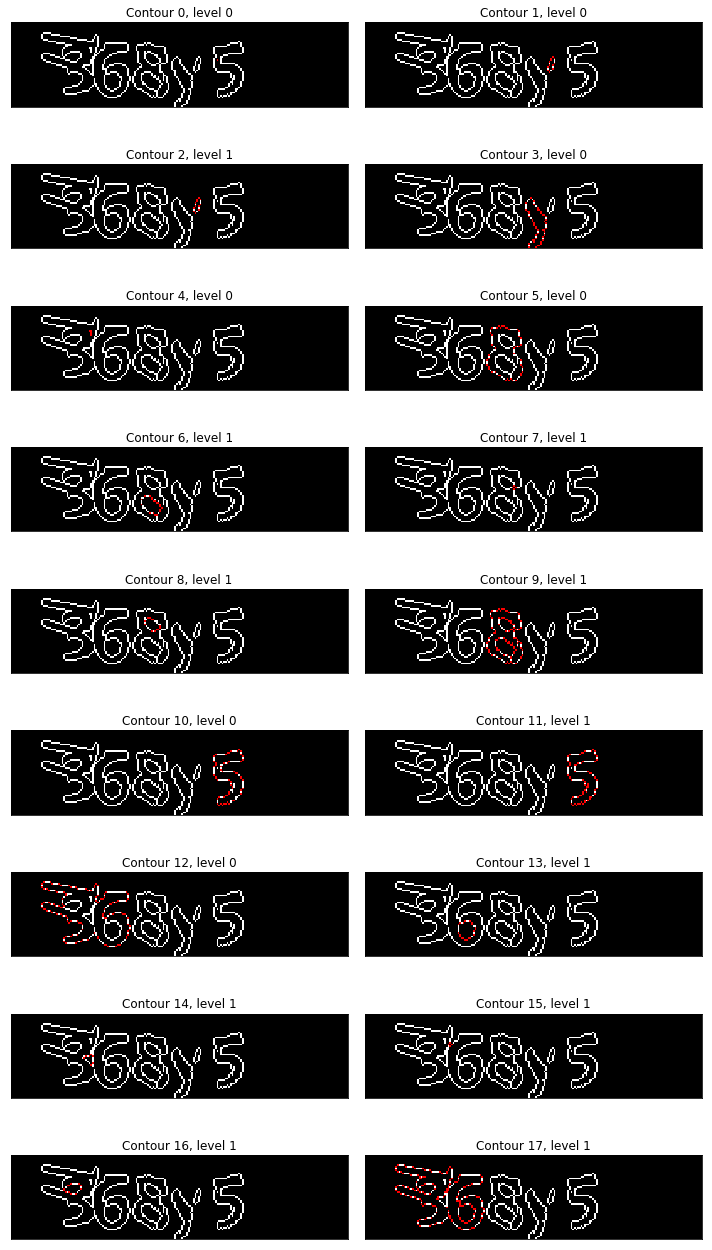

In [14]:
cols = 2
rows = len(contours) // 2
if cols % 2 > 0:
    rows += 1
    
fig, ax = plt.subplots(rows, cols, figsize=(10, rows*2))
for i in range(0, rows):
    for j in range(0, cols):
        index = i * cols + j
        if index >= len(contours):
            ax[i, j].set_visible(False)
        else:
            plt.sca(ax[i, j])
            show_image(cv.drawContours(cv.cvtColor(processed, cv.COLOR_GRAY2RGB), contours[index], -1, (255, 0, 0), 1))
            
            plt.title('Contour {}, level {}'.format(index, contour_levels[index]))
            
plt.tight_layout()
#print(len(contours))

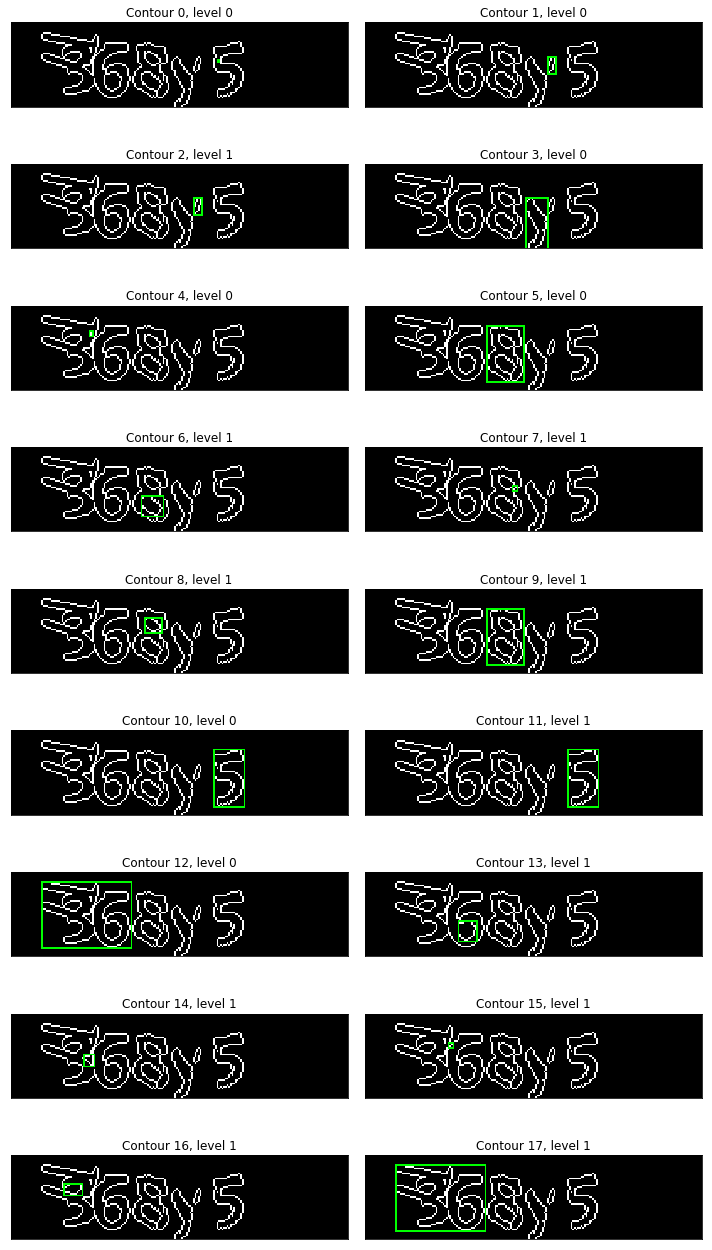

In [15]:
cols = 2
rows = len(contours) // 2
if cols % 2 > 0:
    rows += 1
    
fig, ax = plt.subplots(rows, cols, figsize=(10, rows*2))
for i in range(0, rows):
    for j in range(0, cols):
        index = i * cols + j
        if index >= len(contours):
            ax[i, j].set_visible(False)
        else:
            plt.sca(ax[i, j])
            x,y,w,h = cv.boundingRect(contours[index])
            img = cv.rectangle(cv.cvtColor(processed, cv.COLOR_GRAY2RGB),(x,y),(x+w,y+h),(0,255,0),1)
            show_image(img)
            plt.title('Contour {}, level {}'.format(index, contour_levels[index]))
            

plt.tight_layout()

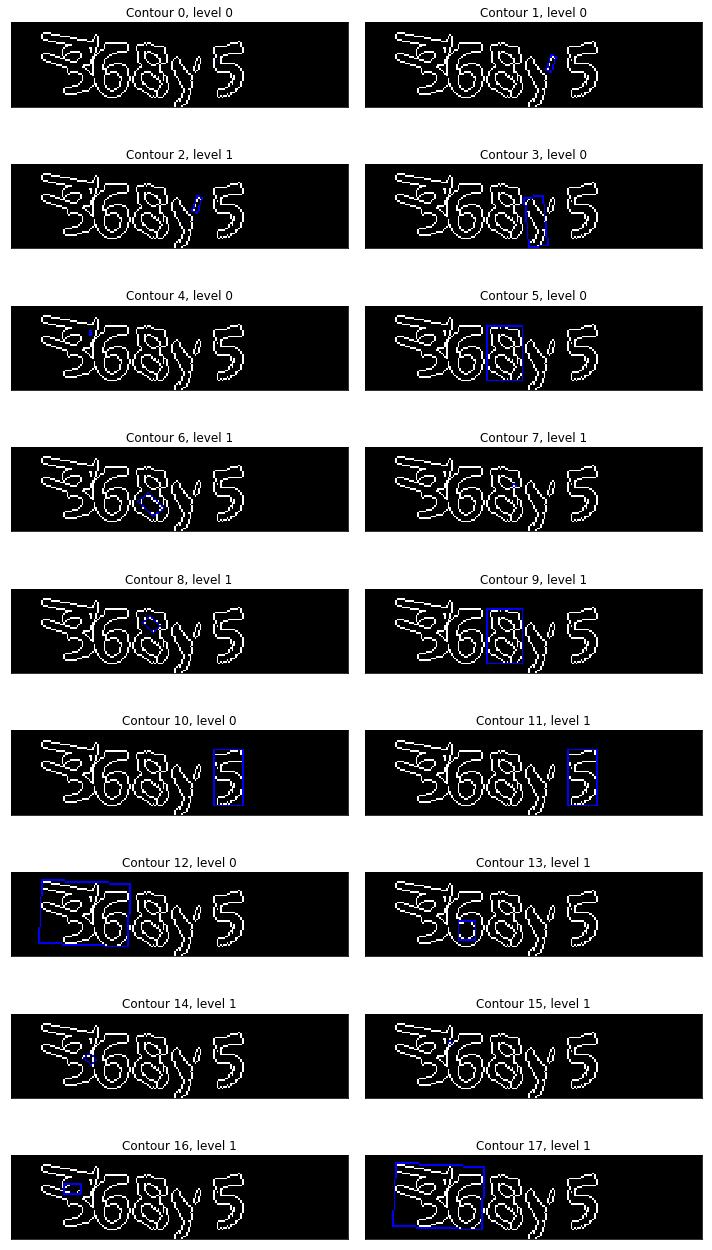

In [16]:
cols = 2
rows = len(contours) // 2
if cols % 2 > 0:
    rows += 1
    
fig, ax = plt.subplots(rows, cols, figsize=(10, rows*2))
for i in range(0, rows):
    for j in range(0, cols):
        index = i * cols + j
        if index >= len(contours):
            ax[i, j].set_visible(False)
        else:
            plt.sca(ax[i, j])
            img = cv.cvtColor(processed, cv.COLOR_GRAY2RGB)
            rect = cv.minAreaRect(contours[index])
            box = cv.boxPoints(rect)
            box = np.int0(box)
            cv.drawContours(img,[box],0,(0,0,255),1)
            show_image(img)
            plt.title('Contour {}, level {}'.format(index, contour_levels[index]))

plt.tight_layout()